# pPXF: MUSE AO NFM spectrum for local merger

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C), substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) and with the inclusion of photometry and linear constraints in [Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022: Created
* V1.1.0: MC, Oxford, 10 June 2022: Updated for `pPXF` 8.1 using the new `ppxf_util.synthetic_photometry`
* V1.2.0: MC, Oxford, 7 September 2022: Updated for pPXF 8.2
* V1.3.0: MC, Oxford, 28 November 2023: Updated for pPXF 9.0 using the new `sps_util`

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)


In [1]:
from os import path
from urllib import request
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
from astropy import constants, units as u
from astropy.io import fits,ascii
import glob

from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

importlib.reload(util)

<module 'ppxf.ppxf_util' from '/disk/bifrost/yuanze/anaconda3/envs/pyqsofit/lib/python3.9/site-packages/ppxf/ppxf_util.py'>

## Setup spectral templates

The template has a larger dispersion than the galaxy: I do **not** broaden the templates.
But I need to correct the measured velocity dispersion later.

The galaxy spectrum was already log-rebinned. I measure the adopted velocity scale for the data.

pPXF can be used with any set of SPS population templates. However, I am currently providing (with permission) ready-to-use template files for three SPS. One can just uncomment one of the three models below. The included files are only a subset of the SPS that can be produced with the models, and one should use the relevant software to produce different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model templates, please also cite [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C) in your paper.

2. If you use the [GALAXEV v2000](http://www.bruzual.org/bc03/) SPS model templates, please also cite [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B) in your paper.

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates, please also cite [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V) in your paper. 
<font color='red'>WARNING: the E-MILES models do not include very young SPS and should not be used for highly star forming galaxies.</font>  

Read SPS models file from my GitHub if not already in the pPXF package dir. I am not distributing the templates with pPXF anymore.
The SPS model files are also available [this GitHub page](https://github.com/micappe/ppxf_data).

In [2]:
sps_name = 'fsps'

ppxf_dir = path.dirname(path.realpath(lib.__file__))
basename = f"spectra_{sps_name}_9.0.npz"
filename = path.join(ppxf_dir, 'sps_models', basename)
if not path.isfile(filename):
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

In [3]:
sps_test=np.load(filename)

In [19]:
sps_test

NpzFile '/disk/bifrost/yuanze/anaconda3/envs/pyqsofit/lib/python3.9/site-packages/ppxf/sps_models/spectra_fsps_9.0.npz' with keys: templates, lam, masses, ages, metals...

The templates are normalized to the V-band using norm_range. In this way the weights returned by pPXF represent V-band light fractions of each SSP.
I limit the age of the templates to the age $T\approx2.2$ Gyr of the Universe at $z=3$.

lam## Read the galaxy spectrum and de-redshift it

In [357]:
lamNew

array([3520.14376326, 3520.61347202, 3521.08324346, ..., 8748.34867083,
       8749.51600271, 8750.68349035])

In [558]:
# %matplotlib widget
# %matplotlib inline

multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="UGC"
psname2="2369"
#RA=[43.507814008,43.507573386,43.50724857]
#DEC=[14.9700775,14.9708075,14.97041556]
obj=1
instru="KCWI"
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]
RA=sentry["RA"].value#[43.507814008,43.507573386,43.50724857]
Dec=sentry["Dec"].value#[14.9700775,14.9708075,14.97041556]
datapath=os.path.join(multiAGNpath,psname1+psname2)
z = sentry["z_sys"][obj-1]
#z = sentry["z_sys"][2]



datapath=os.path.join(multiAGNpath,psname1+psname2)

path_ex = datapath
path_out = os.path.join(datapath, 'KCWI_1D')

data = np.loadtxt(os.path.join(path_out, "KCWI_nuclear_spec_obj{}.txt".format(obj)))
lam = data[:,0]  # OBS wavelength [A]
mask=lam/(1+z)>3520
lam=lam[mask]
flux = data[mask,1]  # OBS flux [1e-16 erg/s/cm^2/A]
err = data[mask,2]  # 1 sigma error
var = err**2
#z = 0.0316  # Initial estimate of the galaxy redshift

velscale=40
#flux[mask]=np.nan
specNew, ln_lam, velscale = util.log_rebin(lam, flux,velscale=velscale)
varNew, _, _ = util.log_rebin(lam,var,velscale=velscale)
lamNew=np.exp(ln_lam)

print(f"Velocity scale per pixel: {velscale:.2f} km/s")

R = 2500
FWHM_gal = np.sqrt(lamNew[0]*lamNew[-1])/R  
print( f"FWHM_gal: {FWHM_gal:.1f} Å")   # 8.5 Angstrom  

c = constants.c.to(u.km/u.s).value                 # speed of light in km/s
sigma_inst = c/(R*2.355)
print( f"sigma_inst: {sigma_inst:.0f} km/s")   # 47 km/s


lamNew /= (1 + z)               # Compute approximate restframe wavelength
FWHM_gal /= (1 + z)     # Adjust resolution in Angstrom
print(f"de-redshifted MUSE AO NFM resolution FWHM in Å: {FWHM_gal:.1f}")

#It is generally simpler to de-redshift the spectrum before performing the pPXF fit.
#Crucially, one has to correct the instrumental resolution in wavelength units too.

# set-up fitting mask and spectrum

galaxy = specNew/np.median(specNew)       # Normalize spectrum to avoid numerical issues


noise = np.sqrt(varNew)/np.median(specNew)       # Assume constant noise per pixel here. I adopt a noise that gives chi2/DOF~1
noise[noise<0.0001]=0.0001
mask0= util.determine_mask(ln_lam, np.exp(ln_lam[[0, -1]]), z, width=1000)
mask= (galaxy>0.0001) & mask0 &   ((lamNew<8560)| (lamNew>8630))#& (lamNew>7000)# & ((lamNew>8000)| (lamNew<8965)) 
#mask= (galaxy>0.0001) &            \
#     ((lamNew<6400)| (lamNew>6765)) \
#    &((lamNew<5590)| (lamNew>5920)) \
#    &((lamNew<4760)| (lamNew>5035))

#Assuming a constant error spectrum `noise` per spectral pixel.
#This is often a good approximation and I can correct later for the scaling, after obtaining the residuials from the fit.


#The stellar templates are reshaped below into a 2-dim array with each spectrum as a column, 
#however we save the original array dimensions ``reg_dim``, which are needed to specify the regularization dimensions
"""
vratio=2 #make over-sample the wavelength grid

sps = lib.sps_lib(filename, velscale/vratio, norm_range=[7000, 8000], age_range=[0, 13.6])
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
stars_templates /= np.median(stars_templates)
n_stars = stars_templates.shape[1]

component = [0]*n_stars
gas_component = np.array(component) > 0  # gas_component=True for gas templates
"""

Velocity scale per pixel: 40.00 km/s
FWHM_gal: 2.3 Å
sigma_inst: 51 km/s
de-redshifted MUSE AO NFM resolution FWHM in Å: 2.2


'\nvratio=2 #make over-sample the wavelength grid\n\nsps = lib.sps_lib(filename, velscale/vratio, norm_range=[7000, 8000], age_range=[0, 13.6])\nreg_dim = sps.templates.shape[1:]\nstars_templates = sps.templates.reshape(sps.templates.shape[0], -1)\nstars_templates /= np.median(stars_templates)\nn_stars = stars_templates.shape[1]\n\ncomponent = [0]*n_stars\ngas_component = np.array(component) > 0  # gas_component=True for gas templates\n'

In [509]:
from ppxf.ppxf_util import log_rebin,gaussian_filter1d

In [276]:
hdu_spmod=fits.open("/disk/bifrost/yuanze/multiAGN/UGC2369/gist-KCWI/spectralTemplates/XSL/XSL_SSP_logT7.7_MH-1.4_Salpeter_PC_lin.fits")
ssp_data       = np.squeeze(hdu_spmod[0].data)
ssp_head       = hdu_spmod[0].header
lamRange_spmod = ssp_head['CRVAL1'] + np.array([0., ssp_head['CDELT1']*(ssp_head['NAXIS1'] - 1)])

In [292]:
lamRange_lin = np.arange( lamRange_spmod[0], lamRange_spmod[-1]+ssp_head['CDELT1'], ssp_head['CDELT1'] )
#FWHM_dif = np.sqrt( LSF_Data(lamRange_lin[idx_lam])**2 - LSF_Templates(lamRange_lin[idx_lam])**2 )

sigma = np.ones(ssp_data.shape)*0.5/2.355/ssp_head['CDELT1']

ssp = gaussian_filter1d(ssp_data, sigma)
sspNew, logLam_spmod, _ = log_rebin(lamRange_spmod, ssp, velscale=velscale)


(-1.0, 3.0)

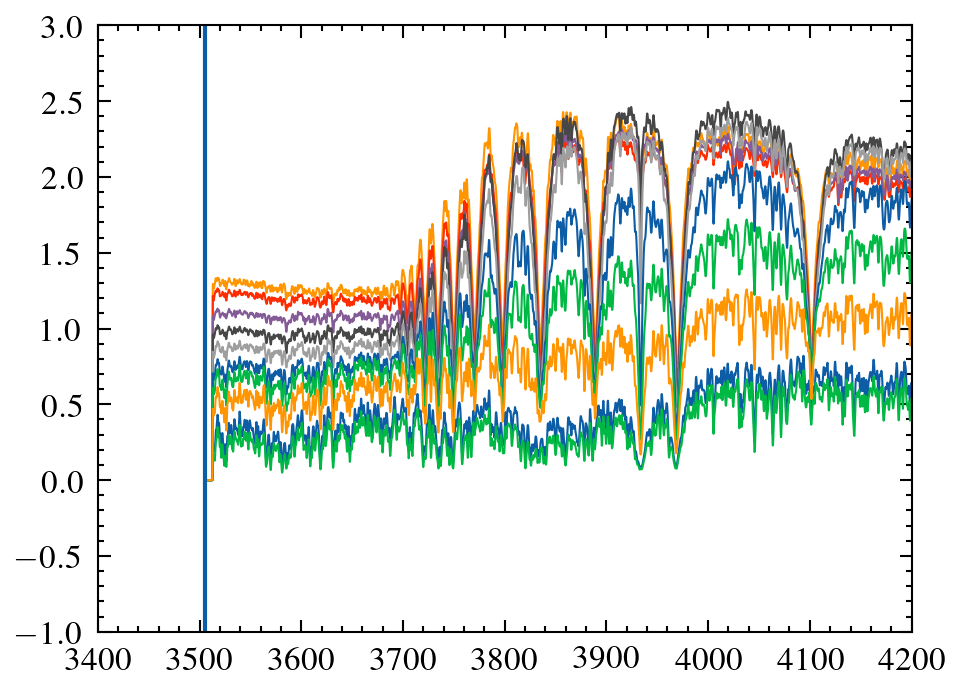

In [440]:
#plt.plot(lamRange_lin,ssp_data)
#plt.plot(np.exp(logLam_spmod)*(1+z),sspNew/np.mean(sspNew))
plt.figure(dpi=300)
for n in range(0,300,30):
    plt.plot(np.exp(logLam2),stars_templates[:,n]/np.median(stars_templates[:,n]),lw=0.5)
#plt.plot(lamNew,galaxy)
plt.xlim(3400,4200)
plt.axvline(3505)
plt.ylim(-1,3)

In [425]:
import sys
sys.path.append('/disk/bifrost/yuanze/software/gist-development')
from gistPipeline.auxiliary._auxiliary import getLSF
from gistPipeline.prepareTemplates import xsl_lin
config={'PREPARE_TEMPLATES':{},'GENERAL':{}}
config['GENERAL']['CONFIG_DIR']="/disk/bifrost/yuanze/multiAGN/UGC2369/gist-KCWI/configFiles"
config['GENERAL']['LSF_DATA']="lsf_KCWI_BR"
config['GENERAL']['LSF_TEMP']="lsf_XSL"
config['GENERAL']['REDSHIFT']=z
config['PREPARE_TEMPLATES']['NORM_TEMP']="LIGHT"
config['GENERAL']['TEMPLATE_DIR']="/disk/bifrost/yuanze/multiAGN/UGC2369/gist-KCWI/spectralTemplates"
config['PREPARE_TEMPLATES']['LIBRARY']="XSL/"


LSF_Data, LSF_Templates=getLSF(config)

templates, lamRange_spmod, logLam2, ntemplates=xsl_lin.prepareSpectralTemplateLibrary(config,3500,9033,velscale/2,LSF_Data,LSF_Templates,False)[:4]
#templates = templates.reshape( (templates.shape[0], ntemplates) )


 [ RUNNING ] Preparing the stellar population templates
 [ DONE    ] Preparing the stellar population templates


In [427]:
offset = (logLam2[0] - ln_lam[0])*c
reg_dim = templates.shape[1:]
stars_templates = templates.reshape(templates.shape[0], -1)
stars_templates /= np.median(stars_templates)
n_stars = stars_templates.shape[1]

component = [0]*n_stars
gas_component = np.array(component) > 0

MUSE AO NFM covers the observed wavelength range $\lambda=470–900$ nm with a quoted resolving power $R \approx 1750-3400$.

We can compute the spectral resolution in wavelength units assuming it is approximately constant. The spectral resolution FWHM is, by definition of resolving power, and using as reference the geometric mean of the wavelength
<br>

$\Delta\lambda=\frac{\lambda}{R}\approx\frac{\sqrt{\lambda_{\rm min}\lambda_{\rm max}}}{R}$

It is also useful to know the instrumental dispersion in km/s
 <br>

$\sigma_{\rm inst}\approx\frac{c}{R\sqrt{4\ln{4}}}$

## Setup pPXF parameters

As the spectrum was deredshifted, the starting guess for the velocity becomes close to zero

In [302]:
#c = 299792.458
start = [100, 200.]     # (km/s), starting guess for [V, sigma]
moments = 4 # Fit (V, sig) moments=2 for the stars and the gas
reg_err=0.1
dust_stars = [{"start": [0.1, -0.1], "bounds": [[0, 4], [-1, 0.4]],"component":~gas_component}]

## Start pPXF fit

In [510]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 4*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

def fit_and_clean(templates, galaxy,noise, velscale, start, goodpixels0, lam,\
                  lam_temp, reg_dim=None,moments=4,regul_err=0.01,dust=None,**kwargs):
    
    print('##############################################################')
#    print(galaxy.shape)
#    print(galaxy)
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, noise, velscale, start,
              moments=moments, degree=8, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels,regul=1/regul_err,dust=dust, reg_dim=reg_dim,**kwargs)

    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)
    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, noise, velscale, start,
              moments=moments, degree=8, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels,regul=1/regul_err,dust=dust, reg_dim=reg_dim,**kwargs)
    
    plt.subplot(122)
    pp.plot()

    plt.savefig(datapath+f"/fig/obj{obj}.pdf",dpi=300)
    optimal_template = templates @ pp.weights
    
    return pp, optimal_template, goodpixels

##############################################################
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       -37       205    -0.154     0.278
chi2/DOF: 141.6; DOF: 5405; degree = 8; mdegree = 4
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/390
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       -11       220    -0.053     0.300
chi2/DOF: 30.95; DOF: 5349; degree = 8; mdegree = 4
method = capfit; Jac calls: 21; Func calls: 194; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/390


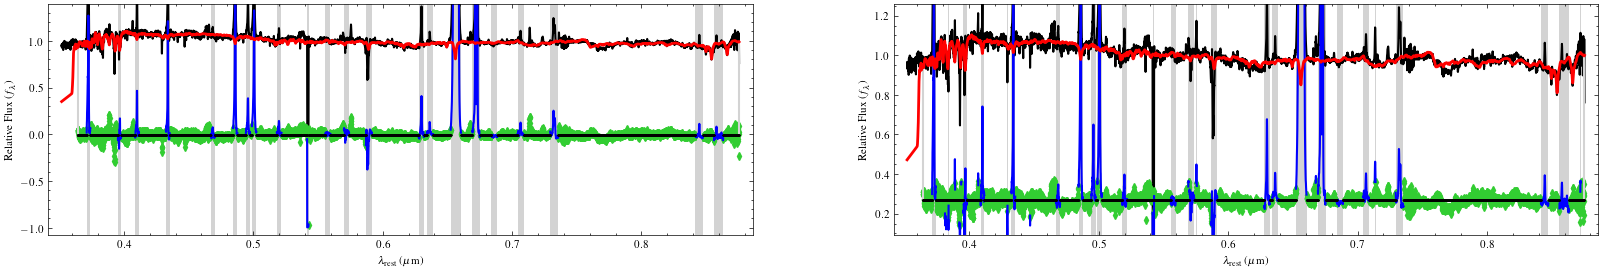

In [552]:
# Measure star dynamics only
#pp = ppxf(stars_templates, galaxy, noise, velscale, start,
#          moments=moments, degree=-1, mdegree=-1, lam=lamNew, mask=mask,lam_temp=sps.lam_temp,
#          reg_dim=reg_dim,
#          reddening=0)
goodpixels0=np.flatnonzero(mask)
#noise  = np.ones(galaxy.shape)
pp, bestfit_template, goodpixs = fit_and_clean(stars_templates, galaxy,noise, velscale, \
                                     start, goodpixels0, lamNew, np.exp(logLam2),\
                                    moments=moments,regul_err=0.1,\
                                     reg_dim=reg_dim,component=component,velscale_ratio=2,bias=0.0)

(3490.0, 3750.0)

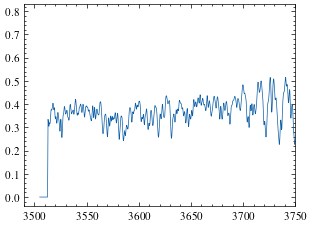

In [534]:
plt.plot(np.exp(logLam2),bestfit_template,lw=0.5,label="Model")
plt.xlim(3490,3750)

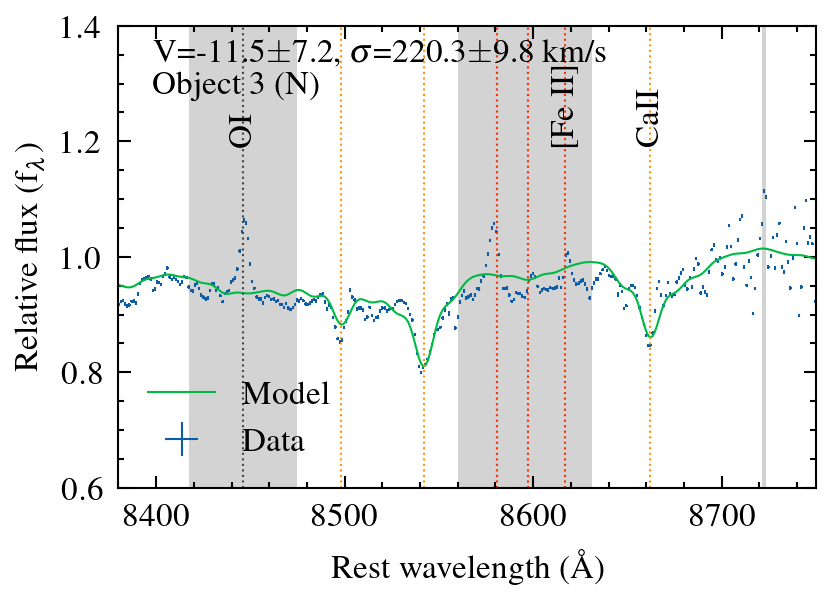

In [553]:
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.],"CaII":[8498, 8542, 8662],'[Fe II]':[8580.78,8597.42,8617.06] ,'OI 7774':[7774],'OI':[8446],'[O III]':[4959,5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.]}#,"Fe II":[6491.28,6385.45,6598.3]}
import scienceplots
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)
rlinec= (1+z)/(z+1)
#rlinec=1
ax.errorbar(lamNew*rlinec,galaxy,fmt="o", ms=0,mfc='none',xerr=0.6,yerr=noise,lw=0.5,label="Data")
#ax.plot(np.exp(Lambda)*rlinec,ESpectra[bin_sel,:],lw=0.5,label="Error")

#ax.plot(np.exp(kinLambda)*rlinec,kinBestfit[bin_sel,:],lw=0.5,label="Model")

#ax.plot(lamNew*rlinec,pp.bestfit,lw=0.5,label="Model")
#ax.plot(np.exp(logLam2),bestfit_template,lw=0.5,label="Model")
ax.plot(lamNew*rlinec,pp.bestfit,lw=0.5,label="Model")
w = np.flatnonzero(np.diff(goodpixs) > 1)
for wj in w:
    a, b = goodpixs[wj : wj + 2]
    ax.axvspan(lamNew[a], lamNew[b], facecolor='lightgray')

ax.set_ylabel(r"Relative flux (f$_{\lambda}$)")
ax.set_xlabel(r"Rest wavelength ($\rm \AA$)")
xlow=8380
xhigh=8750
yup=1.4#np.max(galaxy)*1.2
ylow=0.6#np.min(galaxy)*0.8

plotline=True
if plotline:
    keys=lines.keys()
    for ind,key in enumerate(keys):
        for line in lines[key]:
            if line < xhigh and line > xlow:
                ax.axvline(line,ls=":",c=f"C{ind}",lw=0.5)
    #            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
    #            mask= mask | masktmp
               # print(x[mask])
        if line < xhigh and line > xlow:
            ax.text(line, 0.85*yup,key, rotation=90,verticalalignment='bottom',horizontalalignment='center')
errors = pp.error*np.sqrt(pp.chi2)
pos=["SE","SW","N"]
rstring=rf"V={pp.sol[0]:.1f}$\pm${errors[0]:.1f}, $\sigma$={pp.sol[1]:.1f}$\pm${errors[1]:.1f} km/s"
ax.text(0.05,0.97, rstring, color='black', ha='left', va='top',transform=ax.transAxes)
ax.text(0.05,0.90, f"Object {obj} ({pos[obj-1]})", color='black', ha='left', va='top',transform=ax.transAxes)

ax.legend(loc="lower left")
ax.set_xlim([xlow,xhigh])
ax.set_ylim([ylow,yup])

fig.savefig(datapath+f"/fig/KCWI_fitted_spec_kin_obj{obj}.pdf")

In [554]:
np.savetxt(os.path.join(path_out, "{}_nuclear_spec_ppxfmodel_r0.75_obj{}.txt".format(instru.split("_")[0],obj)),pp.bestfit*np.median(specNew))

In [559]:
np.savetxt(os.path.join(path_out, "wave_ln_binned_obj{}.txt".format(obj)),lamNew*(1+z))

In [550]:
errors = pp.error*np.sqrt(pp.chi2)
vpec = pp.sol[0]                         # This is the fitted residual velocity in km/s
znew = (1 + z)*np.exp(vpec/c) - 1           # eq.(5c) Cappellari (2023)
dznew = (1 + znew)*errors[0]/c              # eq.(5d) Cappellari (2023)
print(f"Best-fitting redshift z = {znew:#.6f} +/- {dznew:#.2g}")

lam_med = np.median(np.exp(ln_lam))  # Angstrom
sigma_gal = c*FWHM_gal/lam_med/2.355  # in km/s
#sigma_temp = c*FWHM_temp/lam_med/2.355
sigma_obs = pp.sol[1]   # sigma is second element of first kinematic component
#sigma_diff2 = sigma_gal**2 - sigma_temp**2   # eq. (5) of Cappellari (2017)
sigma_diff2=0
sigma = np.sqrt(sigma_obs**2 - sigma_diff2)
print(f"sigma stars corrected: {sigma:.1f} km/s")


#Uncertainties on stellar kinematics.
#More accurate ones can be obtained with bootstrapping.

errors = pp.error*np.sqrt(pp.chi2)      # assume the fit is good
print("Formal errors:")
print("   dV   dsigma")
#print("".join("%6.2g" % f for f in errors))
print(errors)

#np.savetxt(path_out+f"/result_obj{obj:s}.txt",np.array([[znew,sigma],[dznew,errors[1]]]))

Best-fitting redshift z = 0.032159 +/- 2.3e-05
sigma stars corrected: 170.3 km/s
Formal errors:
   dV   dsigma
[6.63936591 9.98609427 0.03327225 0.05076432]


In [763]:
lines={"[N I]":[5200.] ,'[Fe VII]':[5721.],'NaD':[5890., 5896.],"CaII":[8498, 8542, 8662],"[O I]":[6302.04,6365.535],"O II":[7319,7330],"[Ar I]":[7067],"HeII":[4687]}#"Fe II":[7155,7172,7388,7453,7637]}

IMPORTANT: As the templates have larger instrumental dispersion than the galaxy spectrum, and for this reason it was not possible to match the resolutions of the templates before the fit, I now need to correct the fitted sigma by the quadratic differences in instrumental resolutions. In this case the correction is negligible, but in general it cannot be ignored.
<br/>

$\sigma_{\rm obs}^2=\sigma_\star^2 + \sigma_{\rm inst}^2$

Uncertainties on stellar kinematics.
More accurate ones can be obtained with bootstrapping.

# Start bootstrapping


In [152]:
np.median(specNew)

3.2861108721870695

In [106]:
import mpdaf

ModuleNotFoundError: No module named 'mpdaf'